In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

In [2]:
import numpy as np
import pandas as pd

In [3]:
import matplotlib.pyplot as plt

In [4]:
import seaborn as sns

In [5]:
spark = SparkSession\
    .builder\
    .appName("PythonSQL")\
    .config("spark.hadoop.fs.s3a.s3guard.ddb.region","us-east-1")\
    .config("spark.yarn.access.hadoopFileSystems","s3a://demo-aws-1/")\
    .getOrCreate()
#.config("spark.hadoop.fs.s3a.s3guard.ddb.region","us-east-2")\

In [6]:
#df = spark.read.csv('data/LoanStats_2015_subset.csv')
#df = spark.read.option('inferschema','true').csv('data/original/LoanStats_2015_subset.csv', header=True)

In [7]:
df = spark.read.option('inferschema','true').csv(
  "s3a://demo-aws-1/datalake/users/pauldefusco/LoanStats_2015_subset.csv",
  header=True,
  sep=',',
  nullValue='NA'
)

In [8]:
df.take(2)

[Row(acc_now_delinq=0, acc_open_past_24mths=8, addr_state='KS', all_util=42, annual_inc=65000.0, annual_inc_joint=None, application_type='Individual', avg_cur_bal=10086, bc_open_to_buy=41055, bc_util=17.1, chargeoff_within_12_mths=0, collections_12_mths_ex_med=0, delinq_2yrs=0, delinq_amnt=0, desc='', dti=23.84, dti_joint=None, earliest_cr_line='Nov-2003', emp_length='10+ years', emp_title='Teacher', funded_amnt='12000', funded_amnt_inv=12000.0, grade='B', home_ownership='MORTGAGE', id='', il_util=61, initial_list_status='w', inq_fi='0', inq_last_12m=0, inq_last_6mths=0, installment=253.79, int_rate='  9.80%', issue_d='Dec-2015', loan_amnt='12000', loan_status='Fully Paid', max_bal_bc='7909', member_id=None, mo_sin_old_il_acct=127, mo_sin_old_rev_tl_op=145, mo_sin_rcnt_rev_tl_op=4, mo_sin_rcnt_tl=1, mort_acc=2, mths_since_last_delinq=None, mths_since_last_major_derog=None, mths_since_last_record=None, mths_since_rcnt_il=1, mths_since_recent_bc=4, mths_since_recent_bc_dlq=None, mths_sin

In [9]:
type(df)

pyspark.sql.dataframe.DataFrame

In [10]:
#df.head()

In [11]:
df.printSchema()

root
 |-- acc_now_delinq: integer (nullable = true)
 |-- acc_open_past_24mths: integer (nullable = true)
 |-- addr_state: string (nullable = true)
 |-- all_util: integer (nullable = true)
 |-- annual_inc: double (nullable = true)
 |-- annual_inc_joint: double (nullable = true)
 |-- application_type: string (nullable = true)
 |-- avg_cur_bal: integer (nullable = true)
 |-- bc_open_to_buy: integer (nullable = true)
 |-- bc_util: double (nullable = true)
 |-- chargeoff_within_12_mths: integer (nullable = true)
 |-- collections_12_mths_ex_med: integer (nullable = true)
 |-- delinq_2yrs: integer (nullable = true)
 |-- delinq_amnt: integer (nullable = true)
 |-- desc: string (nullable = true)
 |-- dti: double (nullable = true)
 |-- dti_joint: double (nullable = true)
 |-- earliest_cr_line: string (nullable = true)
 |-- emp_length: string (nullable = true)
 |-- emp_title: string (nullable = true)
 |-- funded_amnt: string (nullable = true)
 |-- funded_amnt_inv: double (nullable = true)
 |-- gr

In [12]:
#Printing number of rows and columns:
print('Dataframe Shape')
print((df.count(), len(df.columns)))

Dataframe Shape
(421097, 105)


#### Basic Inspection

In [13]:
#Count number of nulls for each column:
df.select([F.count(F.when(F.isnan(c) | F.col(c).isNull(), c)).alias(c) for c in df.columns]).toPandas()

,acc_now_delinq,acc_open_past_24mths,addr_state,all_util,annual_inc,annual_inc_joint,application_type,avg_cur_bal,bc_open_to_buy,bc_util,...,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog
0,3,3,1,399725,3,420586,1,3,3966,4230,...,421097,421097,421097,421097,421097,421097,421097,421097,421097,421097


In [14]:
#It seems like some columns have a lot of nulls while others have very few:
nulls = df.select([F.count(F.when(F.isnan(c) | F.col(c).isNull(), c)).alias(c) for c in df.columns]).toPandas()

In [15]:
null_cols = nulls.T[(nulls.T > 1000).any(axis=1)].index

In [16]:
df = df.drop(*null_cols)

In [17]:
#Printing number of rows:
print('Dataframe Shape')
print((df.count(), len(df.columns)))

Dataframe Shape
(421097, 65)


In [18]:
df = df.filter(df.loan_status != '10500')

In [19]:
df.dtypes

[('acc_now_delinq', 'int'),
 ('acc_open_past_24mths', 'int'),
 ('addr_state', 'string'),
 ('annual_inc', 'double'),
 ('application_type', 'string'),
 ('avg_cur_bal', 'int'),
 ('chargeoff_within_12_mths', 'int'),
 ('collections_12_mths_ex_med', 'int'),
 ('delinq_2yrs', 'int'),
 ('delinq_amnt', 'int'),
 ('desc', 'string'),
 ('dti', 'double'),
 ('earliest_cr_line', 'string'),
 ('emp_length', 'string'),
 ('emp_title', 'string'),
 ('funded_amnt', 'string'),
 ('funded_amnt_inv', 'double'),
 ('grade', 'string'),
 ('home_ownership', 'string'),
 ('id', 'string'),
 ('initial_list_status', 'string'),
 ('inq_last_6mths', 'int'),
 ('installment', 'double'),
 ('int_rate', 'string'),
 ('issue_d', 'string'),
 ('loan_amnt', 'string'),
 ('loan_status', 'string'),
 ('mo_sin_old_rev_tl_op', 'int'),
 ('mo_sin_rcnt_rev_tl_op', 'int'),
 ('mo_sin_rcnt_tl', 'int'),
 ('mort_acc', 'int'),
 ('num_accts_ever_120_pd', 'int'),
 ('num_actv_bc_tl', 'int'),
 ('num_actv_rev_tl', 'int'),
 ('num_bc_sats', 'int'),
 ('num_b

## Section A: KPI Reporting

### What is the target variable and what does it define?

In [20]:
df.select("loan_status").distinct().show()

+------------------+
|       loan_status|
+------------------+
|        Fully Paid|
|           Default|
|   In Grace Period|
|       Charged Off|
|Late (31-120 days)|
|           Current|
|                  |
| Late (16-30 days)|
+------------------+



In [21]:
#Types of loan status
print(df.groupBy('loan_status').count().show())

+------------------+------+
|       loan_status| count|
+------------------+------+
|        Fully Paid|196814|
|           Default|     9|
|   In Grace Period|  2757|
|       Charged Off| 63844|
|Late (31-120 days)|  4905|
|           Current|151713|
|                  |     2|
| Late (16-30 days)|  1052|
+------------------+------+

None


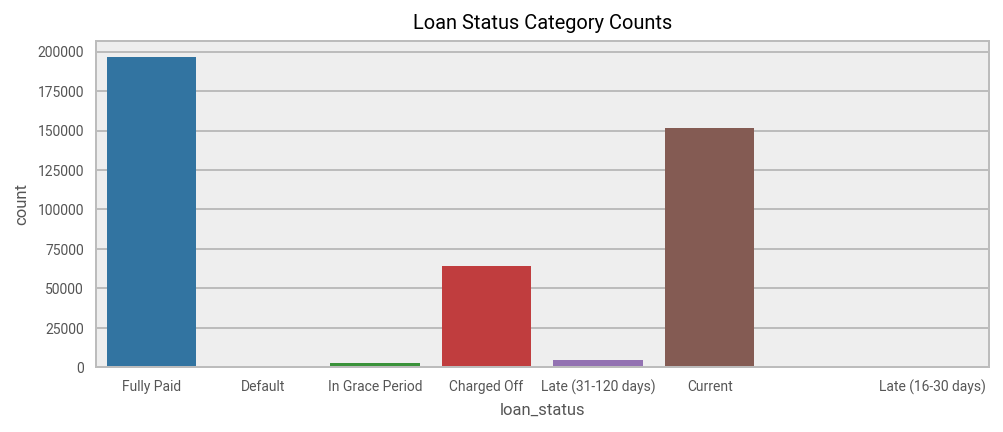

In [22]:
df_plot = df.groupBy('loan_status').count().toPandas()
plt.figure(figsize=(8,3))
g = sns.barplot(x="loan_status", y="count", data=df_plot)
g.set_title('Loan Status Category Counts')
plt.show()

#### To predict defaults, we need to transform the target variable into a binary variable

In [23]:
from pyspark.sql.functions import when

In [24]:
df = df.withColumn("is_default", when((df["loan_status"] == "Charged Off")|(df["loan_status"] == "Default"), 1).otherwise(0))

In [25]:
#Checking that we have correctly replaced values
df.select("is_default").show()

+----------+
|is_default|
+----------+
|         0|
|         0|
|         0|
|         0|
|         0|
|         0|
|         1|
|         0|
|         1|
|         0|
|         0|
|         0|
|         0|
|         0|
|         0|
|         0|
|         0|
|         0|
|         1|
|         0|
+----------+
only showing top 20 rows



In [26]:
df.select("is_default").dtypes

[('is_default', 'int')]

In [27]:
from pyspark.sql import functions as F

In [28]:
#Check the exact total of all loans labeled to default matches with the sum of the original two values used above (Charged Off and Default)
df.select(F.sum("is_default")).collect()[0][0]

63853

### What is the monthly total loan volume in dollars and what is the monthly average loan size?

In [29]:
from pyspark.sql.functions import to_date

In [30]:
#The original issue date attribute
df.select("issue_d").show(4)

+--------+
| issue_d|
+--------+
|Dec-2015|
|Dec-2015|
|Dec-2015|
|Dec-2015|
+--------+
only showing top 4 rows



In [31]:
#We need to cast the issue date from string to month (all loan applications in the dataset occurred in 2015 so we don't need the year):
df.selectExpr("from_unixtime(unix_timestamp(issue_d,'MMM-yyyy'),'MM') as issue_month").show(4)

+-----------+
|issue_month|
+-----------+
|         12|
|         12|
|         12|
|         12|
+-----------+
only showing top 4 rows



In [32]:
df = df.withColumn("issue_month",F.from_unixtime(F.unix_timestamp(F.col("issue_d"),'MMM-yyyy'),'MM'))

In [33]:
df.select("issue_month").distinct().show()

+-----------+
|issue_month|
+-----------+
|         07|
|         11|
|         01|
|       null|
|         09|
|         05|
|         08|
|         03|
|         02|
|         06|
|         10|
|         12|
|         04|
+-----------+



In [34]:
#how many loans defaulted for each month (all data is 2015):
df.groupby('issue_month').sum('is_default').na.drop().sort(F.asc('issue_month')).show()

+-----------+---------------+
|issue_month|sum(is_default)|
+-----------+---------------+
|         01|           5977|
|         02|           3877|
|         03|           4257|
|         04|           5778|
|         05|           5209|
|         06|           4590|
|         07|           7073|
|         08|           5240|
|         09|           4212|
|         10|           6451|
|         11|           5015|
|         12|           6174|
+-----------+---------------+



In [35]:
defaults_date = df.groupby('issue_month').sum('is_default').na.drop().sort(F.asc('issue_month')).toPandas()

In [36]:
defaults_date

,issue_month,sum(is_default)
0,01,5977
1,02,3877
2,03,4257
3,04,5778
4,05,5209
5,06,4590
6,07,7073
7,08,5240
8,09,4212
9,10,6451


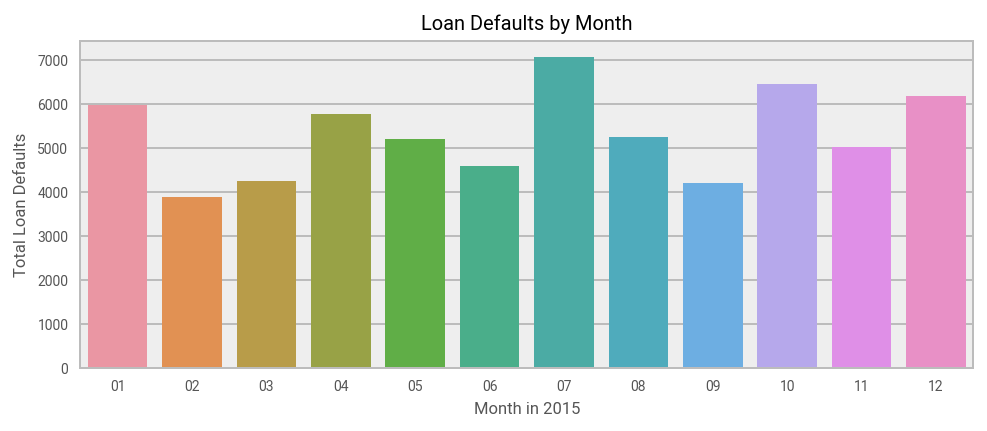

In [37]:
plt.figure(figsize=(8,3))
g = sns.barplot(x="issue_month", y="sum(is_default)", data=defaults_date)
g.set_title('Loan Defaults by Month')
g.set_ylabel('Total Loan Defaults')
g.set_xlabel('Month in 2015')
plt.show()

In [38]:
#Let's create more plots here. First we aggregate in different ways. Then we join, convert to Pandas df, and plot. 

In [39]:
from pyspark.sql.functions import sum as _sum

In [40]:
#by using like function
df.groupBy("issue_month","loan_status").\
count().\
filter(F.lower(F.col("loan_status")).like("late%")).\
groupby('issue_month').\
sum().\
sort(F.asc('issue_month')).\
show()

+-----------+----------+
|issue_month|sum(count)|
+-----------+----------+
|         01|       274|
|         02|       204|
|         03|       291|
|         04|       459|
|         05|       404|
|         06|       410|
|         07|       638|
|         08|       522|
|         09|       482|
|         10|       759|
|         11|       643|
|         12|       871|
+-----------+----------+



In [41]:
df_late = df.groupBy("issue_month","loan_status").\
count().\
filter(F.lower(F.col("loan_status")).like("late%")).\
groupby('issue_month').\
sum().\
sort(F.asc('issue_month'))

In [42]:
#by using like function
df_delinq = df.groupBy("issue_month").\
max("inq_last_6mths").\
na.drop().\
sort(F.asc('issue_month'))

In [43]:
#This time we need to cast the attribute we are working with to numeric before we can create a similar dataframe:
df = df.withColumn('loan_amnt', F.col('loan_amnt').cast('int'))

In [44]:
#by using like function
df_ann_inc = df.groupBy("issue_month").\
mean("loan_amnt").\
na.drop().\
sort(F.asc('issue_month'))

In [45]:
df_delinq.alias('a').join(df_ann_inc.alias('b'),F.col('b.issue_month') == F.col('a.issue_month')).\
join(df_late.alias('c'), F.col('b.issue_month') == F.col('c.issue_month')).\
select(F.col('a.issue_month'), F.col('a.max(inq_last_6mths)'), F.col('b.avg(loan_amnt)'), F.col('c.sum(count)').alias('default_count')).\
show()

+-----------+-------------------+------------------+-------------+
|issue_month|max(inq_last_6mths)|    avg(loan_amnt)|default_count|
+-----------+-------------------+------------------+-------------+
|         01|                  6|15185.933716922551|          274|
|         02|                  6|15435.781447202357|          204|
|         03|                  6| 15354.45964566929|          291|
|         04|                  5|15225.705676461455|          459|
|         05|                  5|15140.835239557548|          404|
|         06|                  5|15087.841846585923|          410|
|         07|                  5|15148.135416213394|          638|
|         08|                  5|15474.875996210221|          522|
|         09|                  5|15720.358926015153|          482|
|         10|                  5|15180.154225786551|          759|
|         11|                  5|15114.503730349054|          643|
|         12|                  5|15062.367228198364|          

In [46]:
df_stats_pd = df_delinq.alias('a').join(df_ann_inc.alias('b'),F.col('b.issue_month') == F.col('a.issue_month')).\
join(df_late.alias('c'), F.col('b.issue_month') == F.col('c.issue_month')).\
select(F.col('a.issue_month'), F.col('a.max(inq_last_6mths)'), F.col('b.avg(loan_amnt)'), F.col('c.sum(count)').alias('default_count')).\
toPandas()

In [47]:
df_stats_pd.head()

,issue_month,max(inq_last_6mths),avg(loan_amnt),default_count
0,01,6,15185.933717,274
1,02,6,15435.781447,204
2,03,6,15354.459646,291
3,04,5,15225.705676,459
4,05,5,15140.835240,404


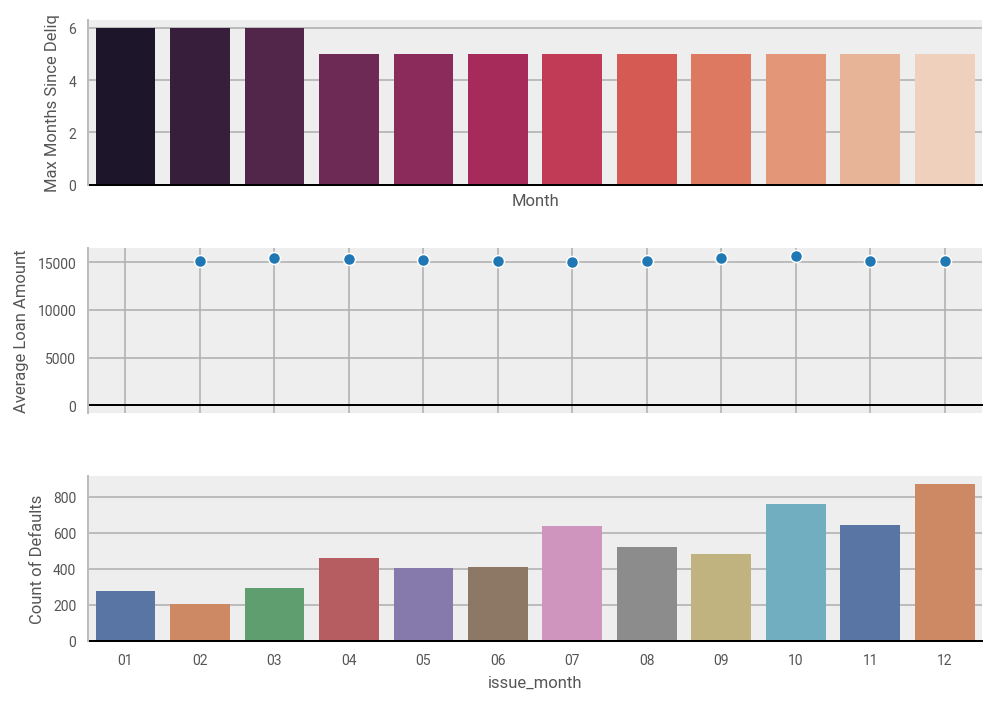

In [48]:
f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(7, 5), sharex=True)

sns.barplot(x=df_stats_pd['issue_month'], y=df_stats_pd['max(inq_last_6mths)'], palette="rocket", ax=ax1)
ax1.axhline(0, color="k", clip_on=False)
ax1.set_ylabel("Max Months Since Deliq")
ax1.set_xlabel("")

sns.scatterplot(x=df_stats_pd['issue_month'], y=df_stats_pd['avg(loan_amnt)'], palette="vlag", ax=ax2)
ax2.axhline(0, color="k", clip_on=False)
ax2.set_ylabel("Average Loan Amount")

sns.barplot(x=df_stats_pd['issue_month'], y=df_stats_pd['default_count'], palette="deep", ax=ax3)
ax3.axhline(0, color="k", clip_on=False)
ax3.set_ylabel("Count of Defaults")
ax1.set_xlabel("Month")

sns.despine(bottom=True)
#plt.setp(f.axes)
plt.tight_layout(h_pad=2)

plt.show()

In [49]:
#do map based on zipcode?

In [50]:
#df = df.filter(df.loan_status != '10500')

### Spark SQL

In [51]:
##Registering the dataframe as a temporary table:
#df.registerTempTable("LC_Loans_2015")

In [52]:
spark.sql("show databases").show()

+--------------------+
|        databaseName|
+--------------------+
|  airline_ontime_orc|
|airline_ontime_pa...|
|     compassion_cube|
|             default|
|  information_schema|
|       prescribing_p|
|          retaildemo|
|                 sys|
+--------------------+



In [53]:
spark.sql("show tables").show()

+--------+-----------+-----------+
|database|  tableName|isTemporary|
+--------+-----------+-----------+
| default|   lc_smote|      false|
| default|   lc_table|      false|
| default|telco_churn|      false|
+--------+-----------+-----------+



In [54]:
#Looks like revol_bal, tax_liens and tot_cur_bal should be numeric. Revol_util should also be numeric but we'll have to remove the % character

In [55]:
df.write.format('parquet').mode("overwrite").saveAsTable('default.LC_table')

In [56]:
#Running SQL like queries on the dataframe 
group_by_grade = spark.sql("SELECT grade, MEAN(loan_amnt) FROM LC_table WHERE grade IS NOT NULL GROUP BY grade ORDER BY grade")

In [57]:
group_by_grade.show()

+-----+------------------+
|grade|    avg(loan_amnt)|
+-----+------------------+
|     |              null|
|    A|14691.902339914912|
|    B|14251.838357212704|
|    C|14745.592284787712|
|    D|15947.183739266447|
|    E| 18472.72662241044|
|    F| 20090.27452378527|
|    G| 20427.83802491924|
+-----+------------------+



In [58]:
#Transforming to pandas
group_by_grade_pd = group_by_grade.toPandas()

In [59]:
#group_by_grade_pd.set_index('grade', inplace=True)

In [60]:
group_by_subgrade = spark.sql("SELECT sub_grade, MEAN(loan_amnt), MEAN(annual_inc), SUM(is_default) FROM LC_table GROUP BY sub_grade ORDER BY sub_grade")

In [61]:
#cache what you are going to use across queries (and early and often up to available memory)
group_by_subgrade.cache()

DataFrame[sub_grade: string, avg(loan_amnt): double, avg(annual_inc): double, sum(is_default): bigint]

In [62]:
%time group_by_grade.show()

+-----+------------------+
|grade|    avg(loan_amnt)|
+-----+------------------+
|     |              null|
|    A|14691.902339914912|
|    B|14251.838357212704|
|    C|14745.592284787712|
|    D|15947.183739266447|
|    E| 18472.72662241044|
|    F| 20090.27452378527|
|    G| 20427.83802491924|
+-----+------------------+

CPU times: user 880 µs, sys: 704 µs, total: 1.58 ms
Wall time: 838 ms


In [63]:
%time group_by_subgrade.show()

+---------+------------------+-----------------+---------------+
|sub_grade|    avg(loan_amnt)|  avg(annual_inc)|sum(is_default)|
+---------+------------------+-----------------+---------------+
|         |              null|             null|              0|
|       A1|14586.086640265094|99901.17048573507|            258|
|       A2|14240.636655390754|90755.41161419029|            379|
|       A3|14373.957663697309| 91224.7539489393|            452|
|       A4|14900.100090404236|90793.96666602092|            801|
|       A5|14984.623140639229|87382.68392905158|           1414|
|       B1|14226.459540188269| 83295.2231897176|           1600|
|       B2|14077.383744531144|  80784.112366154|           1886|
|       B3|15013.303161910946|81092.22305556684|           2339|
|       B4|14455.212977707006|77538.05965923565|           2717|
|       B5| 13427.42992239515|73634.98754972221|           2927|
|       C1|14099.010743739123|73597.44782893245|           3652|
|       C2| 14424.0508315

In [64]:
#caching should reduce loading time for smaller dataframe -- check 
group_by_subgrade.cache()

DataFrame[sub_grade: string, avg(loan_amnt): double, avg(annual_inc): double, sum(is_default): bigint]

In [65]:
%time group_by_subgrade.show()

+---------+------------------+-----------------+---------------+
|sub_grade|    avg(loan_amnt)|  avg(annual_inc)|sum(is_default)|
+---------+------------------+-----------------+---------------+
|         |              null|             null|              0|
|       A1|14586.086640265094|99901.17048573507|            258|
|       A2|14240.636655390754|90755.41161419029|            379|
|       A3|14373.957663697309| 91224.7539489393|            452|
|       A4|14900.100090404236|90793.96666602092|            801|
|       A5|14984.623140639229|87382.68392905158|           1414|
|       B1|14226.459540188269| 83295.2231897176|           1600|
|       B2|14077.383744531144|  80784.112366154|           1886|
|       B3|15013.303161910946|81092.22305556684|           2339|
|       B4|14455.212977707006|77538.05965923565|           2717|
|       B5| 13427.42992239515|73634.98754972221|           2927|
|       C1|14099.010743739123|73597.44782893245|           3652|
|       C2| 14424.0508315

In [66]:
group_by_subgrade_pd = group_by_subgrade.toPandas()

In [67]:
#group_by_subgrade_pd = group_by_subgrade_pd.rename(columns={'avg(CAST(funded_amnt AS DOUBLE))':'avg(funded_amnt)'})

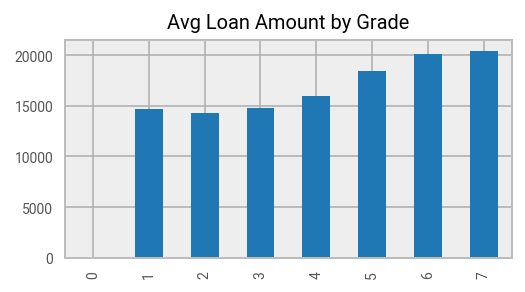

In [68]:
group_by_grade_pd.plot(kind='bar', figsize=(4,2))
plt.title('Avg Loan Amount by Grade')
plt.gca().legend_.remove()
plt.show()
#adjust styling here

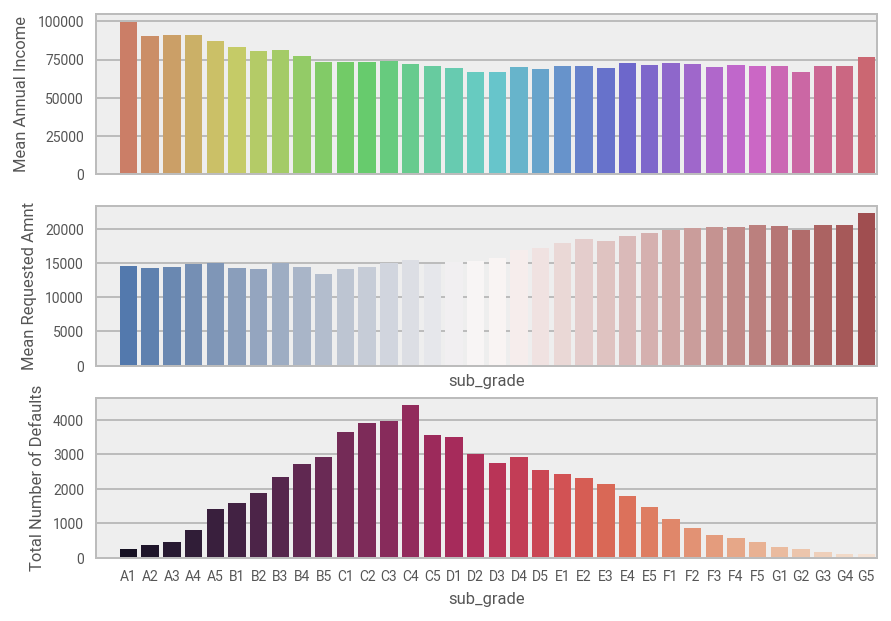

In [69]:
f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(7, 5), sharex=True)

sns.barplot(x=group_by_subgrade_pd['sub_grade'], y=group_by_subgrade_pd['avg(annual_inc)'], palette="hls", ax=ax1)
ax1.axhline(0, color="k", clip_on=False)
ax1.set_ylabel("Mean Annual Income")
ax1.set_xlabel("")

sns.barplot(x=group_by_subgrade_pd['sub_grade'], y=group_by_subgrade_pd['avg(loan_amnt)'], palette="vlag", ax=ax2)
ax2.axhline(0, color="k", clip_on=False)
ax2.set_ylabel("Mean Requested Amnt")
ax1.set_xlabel("")

sns.barplot(x=group_by_subgrade_pd['sub_grade'], y=group_by_subgrade_pd['sum(is_default)'], palette="rocket", ax=ax3)
ax3.axhline(0, color="k", clip_on=False)
ax3.set_ylabel("Total Number of Defaults")

#sns.despine(bottom=True)
#plt.setp(f.axes)
#plt.tight_layout(h_pad=2)

plt.show()

In [70]:
#removing from cache
group_by_grade.unpersist()
group_by_subgrade.unpersist()

DataFrame[sub_grade: string, avg(loan_amnt): double, avg(annual_inc): double, sum(is_default): bigint]

Data Quality Checks

In [71]:
#Check dataframe columnns
#df_new.columns

Checking that correct data types were inferred

In [72]:
df.dtypes 

[('acc_now_delinq', 'int'),
 ('acc_open_past_24mths', 'int'),
 ('addr_state', 'string'),
 ('annual_inc', 'double'),
 ('application_type', 'string'),
 ('avg_cur_bal', 'int'),
 ('chargeoff_within_12_mths', 'int'),
 ('collections_12_mths_ex_med', 'int'),
 ('delinq_2yrs', 'int'),
 ('delinq_amnt', 'int'),
 ('desc', 'string'),
 ('dti', 'double'),
 ('earliest_cr_line', 'string'),
 ('emp_length', 'string'),
 ('emp_title', 'string'),
 ('funded_amnt', 'string'),
 ('funded_amnt_inv', 'double'),
 ('grade', 'string'),
 ('home_ownership', 'string'),
 ('id', 'string'),
 ('initial_list_status', 'string'),
 ('inq_last_6mths', 'int'),
 ('installment', 'double'),
 ('int_rate', 'string'),
 ('issue_d', 'string'),
 ('loan_amnt', 'int'),
 ('loan_status', 'string'),
 ('mo_sin_old_rev_tl_op', 'int'),
 ('mo_sin_rcnt_rev_tl_op', 'int'),
 ('mo_sin_rcnt_tl', 'int'),
 ('mort_acc', 'int'),
 ('num_accts_ever_120_pd', 'int'),
 ('num_actv_bc_tl', 'int'),
 ('num_actv_rev_tl', 'int'),
 ('num_bc_sats', 'int'),
 ('num_bc_t

In [73]:
#The following attributes are strings but they potentially should be numeric. Let's take a look at a sample.
df.select('revol_bal', 'revol_util', 'tax_liens', 'tot_cur_bal', 'int_rate', 'emp_length').show()

+---------+----------+---------+-----------+--------+----------+
|revol_bal|revol_util|tax_liens|tot_cur_bal|int_rate|emp_length|
+---------+----------+---------+-----------+--------+----------+
|     9786|     13.4%|        0|     181540|   9.80%| 10+ years|
|    19339|     42.5%|        0|     430856|   5.32%|    1 year|
|    43413|     51.9%|        0|     193745|  18.49%| 10+ years|
|    21831|     50.3%|        0|     408118|  15.77%|   2 years|
|    12900|    102.4%|        0|     133285|  19.89%|  < 1 year|
|    28475|     51.8%|        0|      42952|  10.78%|   8 years|
|     7179|     39.7%|        0|      10353|  16.59%|   5 years|
|    20862|     54.3%|        0|     305781|   7.49%| 10+ years|
|    31200|       42%|        0|      34856|  13.99%| 10+ years|
|    11008|     41.4%|        0|      31915|  10.78%|   3 years|
|    28705|     56.3%|        0|     265836|  12.88%|    1 year|
|    51507|     64.5%|        0|     221110|   6.49%| 10+ years|
|      732|     31.1%|   

In [74]:
#from pyspark.sql.functions import substring
#df_ml = df_ml.withColumn("manufacturer", substring(col("manufacturer"), 0, 5))

In [75]:
#telco_data\
#  .write.format("parquet")\
#  .mode("overwrite")\
#  .saveAsTable(
#    'default.telco_churn'
#)

In [76]:
#Removing the % character from revol_util
df = df.withColumn("revol_util", F.expr("substring(revol_util, 1, length(revol_util)-1)"))

In [77]:
#Removing the % character from revol_util
df = df.withColumn("int_rate", F.expr("substring(int_rate, 1, length(revol_util)-1)"))

In [78]:
#Notice that we are not casting emp_length to numeric as the time periods it represents are different - it will have to be one hot encoded
integer = ["revol_bal", "tax_liens", "tot_cur_bal", "funded_amnt"]

In [79]:
for c in integer:
    df = df.withColumn(c, df[c].cast("int"))

In [80]:
#Updating revol_util to double:
df = df.withColumn('revol_util', F.col('revol_util').cast('double'))

In [81]:
#Updating int_rate to double:
df = df.withColumn('int_rate', F.col('int_rate').cast('double'))

In [82]:
for c in integer:
    df = df.withColumn(c, F.col(c).cast('int'))

In [ ]:
df.write.format('parquet').mode("overwrite").saveAsTable('default.LC_table')

In [ ]:
##Registering the dataframe as a temporary table:
#Temporary views in Spark SQL are session-scoped and will disappear if the session that creates it terminates. 
#If you want to have a temporary view that is shared among all sessions and keep alive until the Spark application terminates, 
#you can create a global temporary view

df.createOrReplaceTempView("LC_Glob_Temp_View")

In [ ]:
spark.sql("show tables").show()

In [ ]:
spark.catalog.dropTempView("LC_Glob_Temp_View")

In [ ]:
spark.sql("show tables").show()

In [ ]:
#spark.catalog.dropGlobalTempView("LC_Loans_2015_GlobalTempView")

In [ ]:
spark.sql("SELECT * FROM default.LC_table")